CLARA Clustering multiprocessing

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn_extra.cluster import CLARA
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score,normalized_mutual_info_score,silhouette_score,davies_bouldin_score,calinski_harabasz_score
import ray
import dill
import time

#Initiation du framework Ray pour gerer les taches paralleles
ray.init(ignore_reinit_error=True,  local_mode=True,object_store_memory=3 * 1024 ** 3)

#Chargement et preparation du dataset
def load_and_prepare_data(file_path):
    data = pd.read_csv(file_path) #Chargement du fichier CSV
    data.drop(columns=['CUST_ID'], inplace=True)  #Suppression de la colonnes d'identifiant inutile
    data.fillna(data.median(), inplace=True)  #Remplacement des valeurs manquantes par la mediane
    numeric_data = data.select_dtypes(include=[np.number])  #Selection des colonnes numeriques uniquement
    return (numeric_data - numeric_data.mean()) / numeric_data.std() #Normalisation du data

#Appliquation de l'algorithme CLARA Clustering
@ray.remote #transforme la fonction apply_clara en une tache qui peut etre excecutee en parallle
def apply_clara(data_array, k, sampling_size, random_state):
    data = pd.DataFrame(data_array)  
    clara = CLARA(n_clusters=k, n_sampling=sampling_size, random_state=random_state)
    labels = clara.fit_predict(data)#Effectuer le Clustering 
    return clara, labels

# Sauvegarde du modèle
def save_model(model, filename="model_clara.pkl"):
    with open(filename, 'wb') as file:
        dill.dump(model, file)
    
def clara_model(file, n_clusters):
    #Chargement des donnees
    data = load_and_prepare_data(file)
    data_array = data.to_numpy()

    random_states = [42, 43, 44, 45]

    #Chronometrer l'exécution
    start_time = time.time()

    sampling_size = max(int(0.05 * len(data)), n_clusters + 1)  #Taille des sous-echantillons(samples)

    #Creation des taches paralleles pour Ray, chaque tache s'excecute avec un state different
    
    tasks = [apply_clara.remote(data_array, n_clusters, sampling_size, state) for state in random_states]

    #Execution des taches en parallele avec Ray
    results = ray.get(tasks)

    end_time = time.time()

    temps_execution = end_time - start_time

    #Selection du premier resultat retourner par les taches parallele
    best_clara, labels = results[0]
    
    #Enregistrer Model CLARA Clustering
    save_model(best_clara, 'model_clara.pkl')

    #Evaluation des clusters
    metrics = evaluate_clustering(data, labels)

    ray.shutdown()

    return best_clara, labels, metrics, temps_execution

#Metriques d'evaluation
def evaluate_clustering(data, labels):
    #Usupervised
    silhouette = silhouette_score(data, labels)
    db_index = davies_bouldin_score(data, labels)
    ch_score = calinski_harabasz_score(data, labels)

    print(f"Silhouette Coefficient : {silhouette:.4f}")
    print(f"Davies-Bouldin Index : {db_index:.4f}")
    print(f"Calinski-Harabasz Index : {ch_score:.4f}")
    
    #Supervised (on n'a pas des labels deja classifier/Clustered)
    true_labels = None  
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, labels)
        nmi = normalized_mutual_info_score(true_labels, labels)
        print(f"Adjusted Rand Index (ARI) : {ari:.4f}")
        print(f"Normalized Mutual Information (NMI) : {nmi:.4f}")

model, labels, metrics, temps_execution = clara_model("credit_cards.csv", n_clusters=6)



2025-01-13 18:44:36,148	INFO worker.py:1821 -- Started a local Ray instance.


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


:task_name:apply_clara


Silhouette Coefficient : 0.1233
Davies-Bouldin Index : 1.7780
Calinski-Harabasz Index : 1096.5523


In [4]:
# Chargement du modèle sauvegardé
def load_model(filename):
    with open(filename, 'rb') as file:
        model = dill.load(file)
    print("📦 Modèle CLARA chargé avec succès !")
    return model
clara_loaded = load_model('model_clara.pkl')
clara_loaded

📦 Modèle CLARA chargé avec succès !


CLARA(n_clusters=6, n_sampling=447, random_state=42)

c:\Users\info\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\info\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\info\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\info\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127942 (\N{TROPHY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\info\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Use

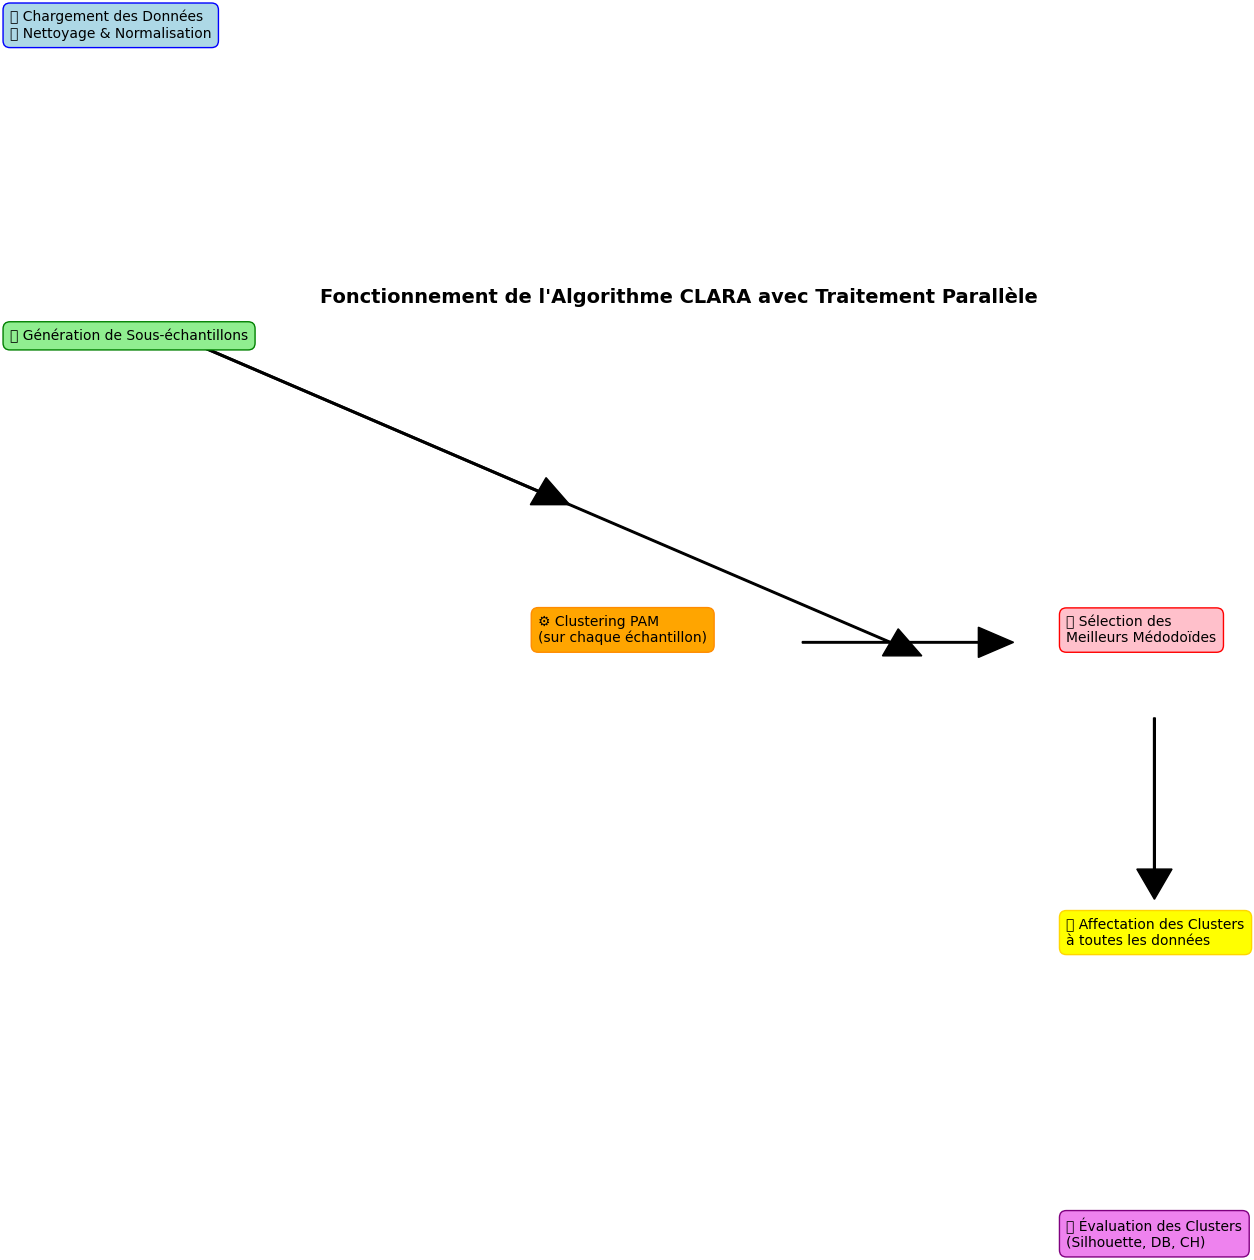

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_clara_parallel():
    fig, ax = plt.subplots(figsize=(14, 8))

    # Bloc 1: Préparation des données
    ax.text(0.1, 0.9, "📂 Chargement des Données\n🔍 Nettoyage & Normalisation", 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightblue", ec="blue"), fontsize=10)

    # Bloc 2: Échantillonnage
    ax.text(0.1, 0.7, "🎲 Génération de Sous-échantillons", 
            bbox=dict(boxstyle="round,pad=0.5", fc="lightgreen", ec="green"), fontsize=10)

    # Bloc 3: Processus Parallèle
    ax.text(0.4, 0.5, "⚙️ Clustering PAM\n(sur chaque échantillon)", 
            bbox=dict(boxstyle="round,pad=0.5", fc="orange", ec="darkorange"), fontsize=10)
    
    ax.arrow(0.2, 0.7, 0.2, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    ax.arrow(0.2, 0.7, 0.4, -0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

    # Bloc 4: Sélection du meilleur modèle
    ax.text(0.7, 0.5, "🏆 Sélection des\nMeilleurs Médodoïdes", 
            bbox=dict(boxstyle="round,pad=0.5", fc="pink", ec="red"), fontsize=10)
    
    ax.arrow(0.55, 0.5, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')

    # Bloc 5: Affectation Globale
    ax.text(0.7, 0.3, "🔄 Affectation des Clusters\nà toutes les données", 
            bbox=dict(boxstyle="round,pad=0.5", fc="yellow", ec="gold"), fontsize=10)
    
    ax.arrow(0.75, 0.45, 0, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')

    # Bloc 6: Évaluation
    ax.text(0.7, 0.1, "📈 Évaluation des Clusters\n(Silhouette, DB, CH)", 
            bbox=dict(boxstyle="round,pad=0.5", fc="violet", ec="purple"), fontsize=10)
    
    # Supprimer les axes
    ax.axis('off')

    plt.title("Fonctionnement de l'Algorithme CLARA avec Traitement Parallèle", fontsize=14, fontweight='bold')
    plt.show()

plot_clara_parallel()
